# Sea surface temperature

In [22]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc
from collections import OrderedDict
import pandas as pd

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load simulations

In [23]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']
c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale

loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0031-01-01'
end_date = '0061-12-31'
start_year = int(start_date[:4])
end_year = int(end_date[:4])

alpha_res = 2.
p_res = 50
def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)

In [24]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 6

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300612')
    cluster.scale(nw)
    client = Client(cluster)

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

In [25]:
%%time
# -------------------------------------------------------------------
res_funcs         = []   # time-mean resolution functions
# -------------------------------------------------------------------
# 3.  Loop over simulations
for i, sim in enumerate(sims):
    # ── open data
    sim.open_files_by_year(sim.ocn_data_path, sim.native_end, start_year, end_year)
    sim.open_grid()
    ds = sim.ds.sel(time=slice(start_date, end_date))

    Rd_dx       = ds.Rd_dx.mean('time').compute()
    res_funcs.append(resolution(Rd_dx, alpha_res, p_res))





Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
CPU times: user 1min 21s, sys: 9.31 s, total: 1min 30s
Wall time: 3min 42s


### Plot sea surface temperature

In [26]:
analysis_dir = '/glade/work/yhoussam/analysis_mom6/backscatter/61years'
file = 'thetao_time_mean'
paths=[]
for case_name in case_names:
    path = return_ncfile_path(analysis_dir,case_name,file)
    paths.append(path)


for i in range(num_sims):
    sim = sims[i]
    sim.open_ncfile(paths[i])
    sim.open_grid()

Opened file.
Opened grid and assigned coordinates.
Opened file.
Opened grid and assigned coordinates.
Opened file.
Opened grid and assigned coordinates.
Opened file.
Opened grid and assigned coordinates.


In [27]:
datas=[]
for i in range(num_sims):
    sim = sims[i]
    data = sim.ds.thetao_bias
    depth=0
    index = (np.abs(data.z_l - depth)).argmin().item()
    depth = data.z_l[index].item()
    data = data.isel(z_l=index)
    
    data = data.assign_coords({'geolon': sim.grid['geolon'],
                       'geolat': sim.grid['geolat']})
    datas.append(data)

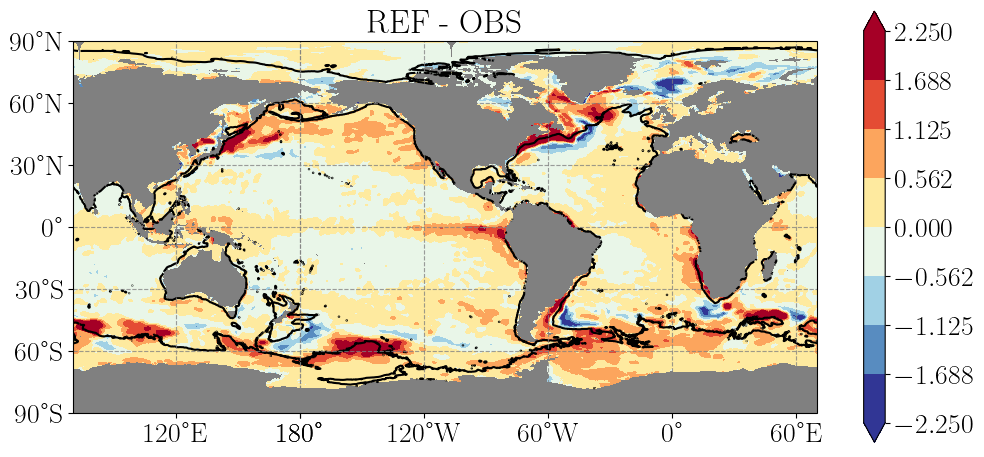

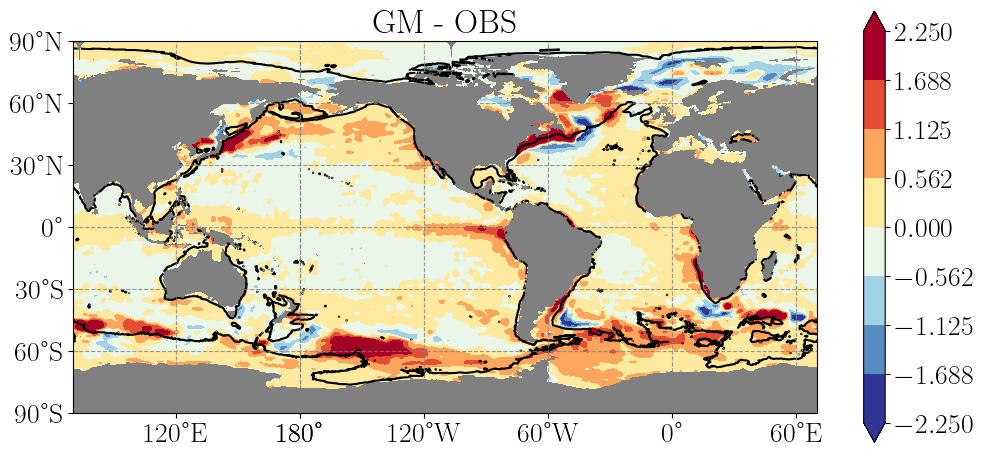

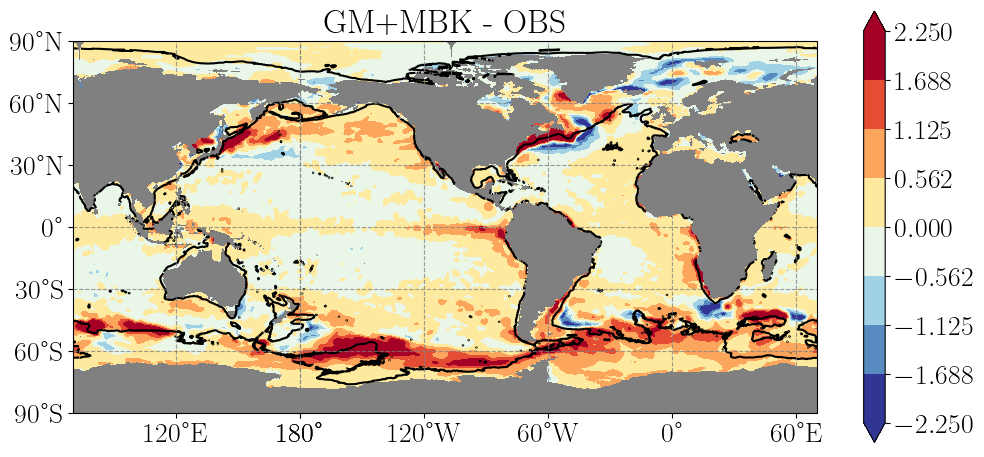

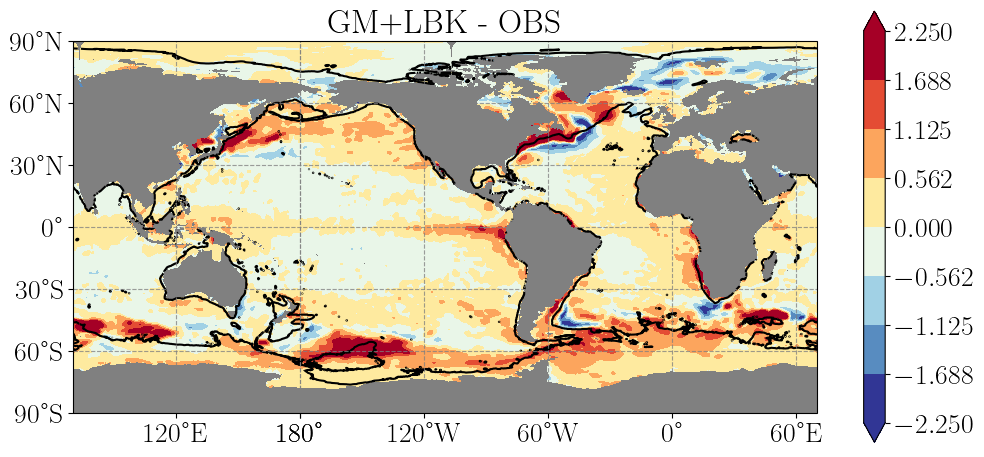

In [28]:
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = -2.25, 2.25
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)

for sim, R, data in zip(sims, res_funcs, datas):
    title = sim.short_name + " - OBS"
    # pass norm instead of vmin/vmax
    mappable = sim.plot_global_discrete(data,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+"SST_"+title+'.png',dpi=300)

### Plot difference with reference simulation

In [29]:
diffs = []
for i in range(1,num_sims):
    diff = datas[i].fillna(0)-datas[0].fillna(0)
    diff = diff.assign_coords({'geolon': sims[0].grid['geolon'],
                       'geolat': sims[0].grid['geolat']})
    diff = diff.where(diff != 0, np.nan)
    diffs.append(diff)

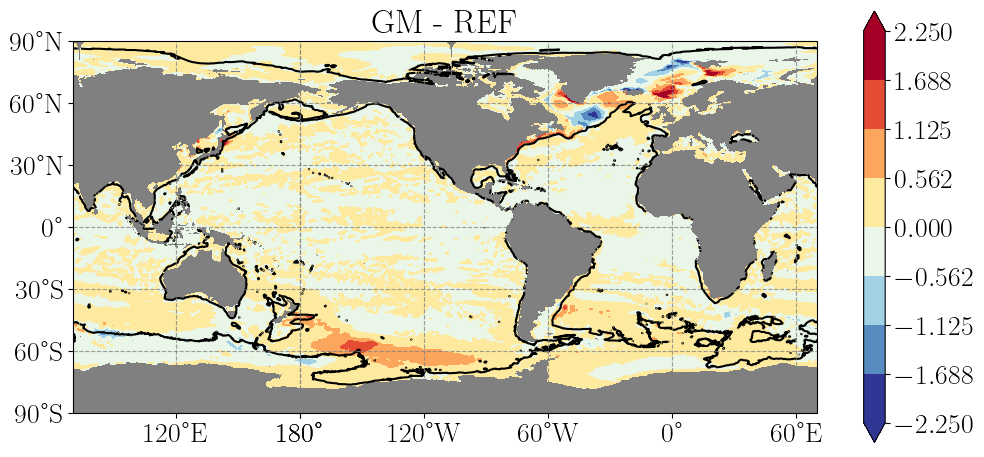

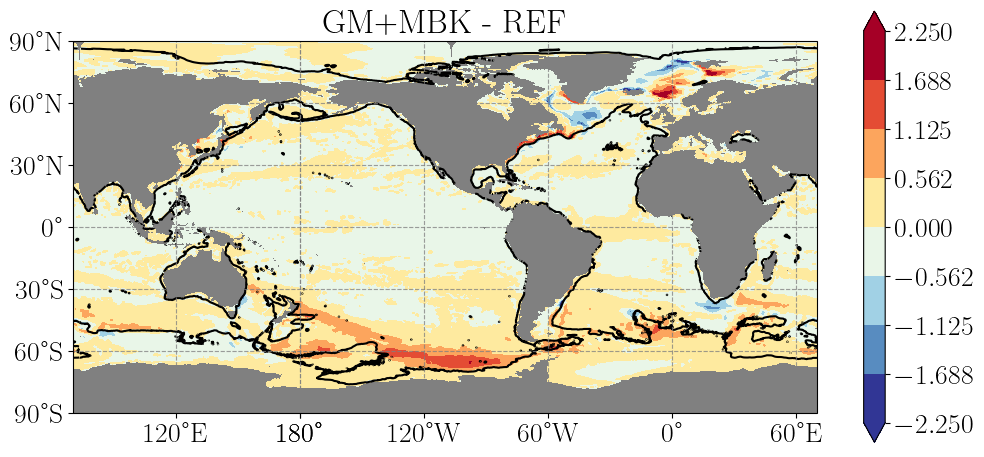

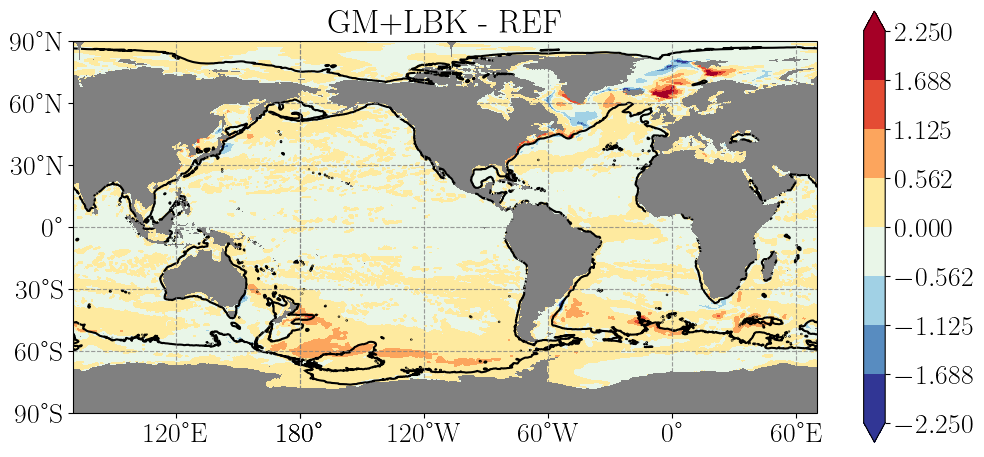

In [30]:
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = -2.25, 2.25
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)

for sim, R, diff in zip(sims[1:], res_funcs[1:], diffs):
    title = sim.short_name + " - REF"
    # pass norm instead of vmin/vmax
    mappable = sim.plot_global_discrete(diff,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+"SST_"+title+'.png',dpi=300)